In [1]:
from __future__ import print_function
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import torch
import torch.nn.functional as F
import numpy as np

### Set up the visible GPU

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


### Load the datasets

In [3]:
# load the training images and the semantic segmentation image (mask image)
train = '/home/xiaoyu/data_semantics/training/test/image'
train_mask = '/home/xiaoyu/data_semantics/training/test/mask/'

trainimage = os.listdir(train)
trainmask = os.listdir(train_mask)

print(trainimage[0])

print("Training images numbers for different folder of training images: "+str(len(trainimage)))
print("Training mask Images numbers:"+str(len(trainmask)))
image_ex = trainimage[0]
print(image_ex)

000001_10.png
Training images numbers for different folder of training images: 2
Training mask Images numbers:2
000001_10.png


### Observe the image data

In [4]:
print("The image size is:" + str(io.imread(os.path.join(train, image_ex)).shape))
print("The mask size is:" + str(io.imread(os.path.join(train_mask, image_ex)).shape))
print('The data type of image is: ' + str(io.imread(os.path.join(train,image_ex)).dtype))
print('The data type of mask is: ' + str(io.imread(os.path.join(train_mask,image_ex)).dtype))
print('The type of image is: ' + str(type(io.imread(os.path.join(train,image_ex)))))


The image size is:(375, 1242, 3)
The mask size is:(375, 1242, 3)
The data type of image is: uint8
The data type of mask is: uint8
The type of image is: <class 'numpy.ndarray'>


### Data visualization

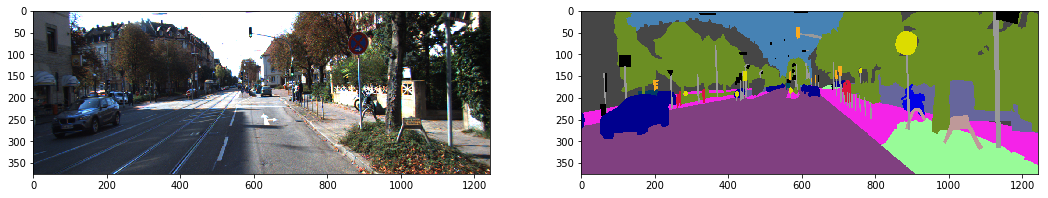

In [5]:
def show_semantic(image, semantic):
    """
    Show images with semantic segmentation
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The traing image semantic segmentation
    """

    plt.subplot(1,2,1)
    plt.imshow(image, aspect='auto')
    plt.subplot(1,2,2)
    plt.imshow(semantic, aspect='auto')
    plt.show()
    
# test the function
plt.figure(figsize=(18, 3))
show_semantic(io.imread(os.path.join(train,image_ex)), 
              io.imread(os.path.join(train_mask,image_ex)))

## Preprocessing of the images
### Traindataset class definition

In [6]:
class TrainDataset(Dataset):
    """Training dataset with mask image on gray scale/RGB"""
    def __init__(self, train_dir, semantic_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.train_dir = train_dir
        self.transform = transform
        self.semantic_dir = semantic_dir       
    def __len__(self):
        return len(os.listdir(self.train_dir))
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.train_dir, os.listdir(self.train_dir)[idx])
        semantic_name = os.path.join(self.semantic_dir, os.listdir(self.semantic_dir)[idx])
        image = io.imread(img_name)
        semantic = io.imread(semantic_name) 
        sample = {'image':image, 'semantic':semantic}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

<class 'dict'>
0 (375, 1242, 3) (375, 1242, 3)


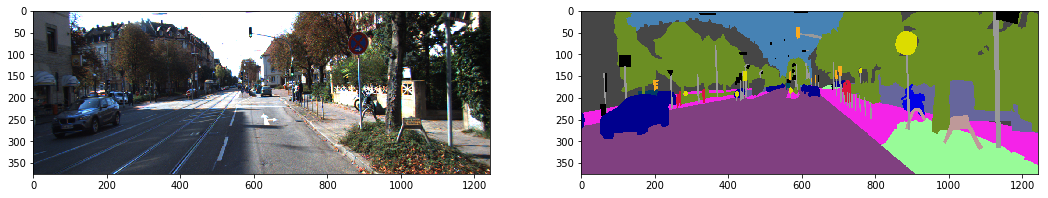

1 (375, 1242, 3) (375, 1242, 3)


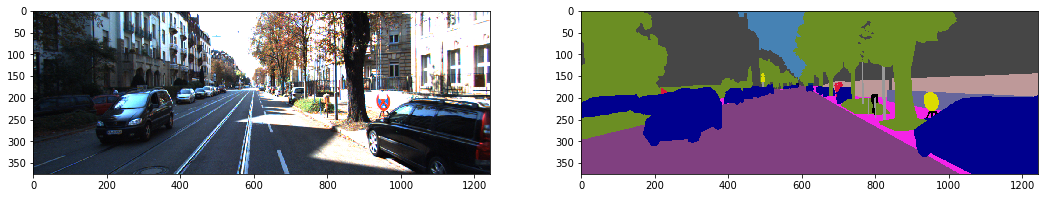

In [7]:
# test the traindataset class without transforms
train_data = TrainDataset(train_dir=train, semantic_dir =train_mask)
print(type(train_data[0]))

for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample['image'].shape, sample['semantic'].shape)
    plt.figure(figsize=(18, 3))
    show_semantic(sample['image'],sample['semantic'])
    
    if i == 1:  
        break

In [8]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        semantic = semantic[top: top + new_h, left: left + new_w]

        return {'image': image, 'semantic': semantic}

In [9]:
class ToTensor(object):
    """Convert ndarrays in sample (both the original image 
    and the semantic image to Tensors"""
    
    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']
        
        #swap color axis because
        #numpy image: H x W x C
        #torch image: C x H x W
        image = image.transpose((2, 0, 1))
        semantic = semantic.transpose((2,0,1))
        return {'image': torch.from_numpy(image),
                'semantic': torch.from_numpy(semantic)}

The original image:


<Figure size 432x288 with 0 Axes>

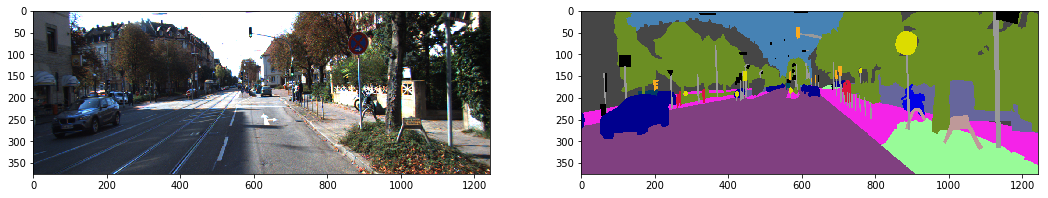

The cropped image:


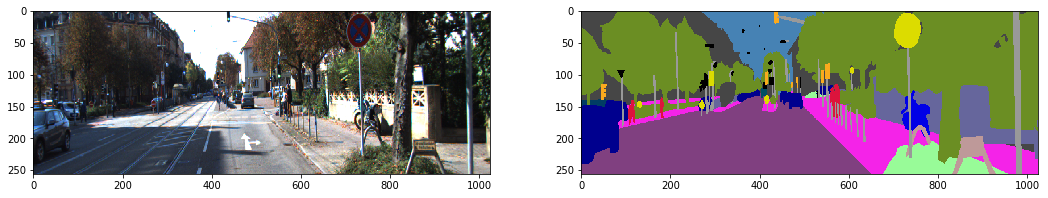

The composed transformed image:
(256, 1024, 3)


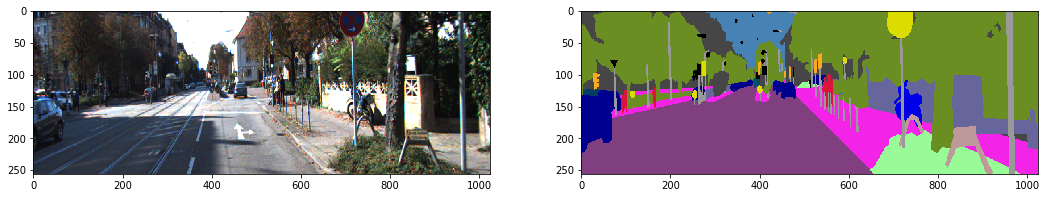

In [10]:
# test of the tress preprocessing of the image functions
crop = RandomCrop((256,1024))
composed = transforms.Compose([RandomCrop((256,1024))])

fig = plt.figure()
sample = train_data[0]

print("The original image:")
plt.figure(figsize=(18, 3))
show_semantic(**sample)

print("The cropped image:")
croped_sample = crop(sample)
plt.figure(figsize=(18, 3))
show_semantic(**croped_sample)

print("The composed transformed image:")
composed_sample = composed(sample)
print(composed_sample['image'].shape)
plt.figure(figsize=(18, 3))
show_semantic(**composed_sample)

### Make several transformed datasets, which are subsets of the datasets

In [11]:
# the composed transform
composed = transforms.Compose([ToTensor()])
transformed_dataset= TrainDataset(train_dir=train, semantic_dir =train_mask, transform = composed)

In [12]:
# Test the transformed dataset, visualize of the size of the transformed dataset.
print(type(transformed_dataset))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].type(torch.FloatTensor).dtype, sample['semantic'].dtype)
    
    if i == 3:
        break

print("Transformed_dataset is : " + str(type(transformed_dataset)))

<class '__main__.TrainDataset'>
0 torch.float32 torch.uint8
1 torch.float32 torch.uint8
Transformed_dataset is : <class '__main__.TrainDataset'>


### Dataloader class is used for: 
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.
* ```torch.utils.data.DataLoader``` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [13]:
dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle = False, num_workers = 4)  

In [14]:
print(len(dataloader))

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch)
    print(sample_batched['image'].size())
    print(sample_batched['semantic'].size())
    if i_batch ==0:
        break

2
0
torch.Size([1, 3, 375, 1242])
torch.Size([1, 3, 375, 1242])


In [15]:
# Helper function to show a batch
def show_semantic_batch(sample_batched):
    """Show original images and semantic images for a batch of samples"""
    images_batch, semantic_batch = \
            sample_batched['image'], sample_batched['semantic']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    grid_semantic = utils.make_grid(semantic_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.pause(0.5)
    plt.imshow(grid_semantic.numpy().transpose((1,2,0)))
 

0 torch.Size([1, 3, 375, 1242]) torch.Size([1, 3, 375, 1242])
torch.uint8


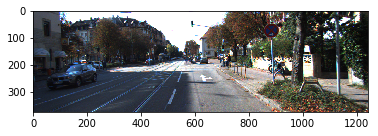

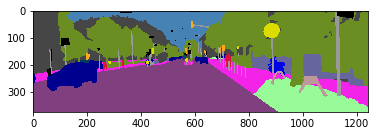

In [16]:
for i_batch, (inputs, target) in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['semantic'].size())
    print(sample_batched['image'].dtype)
    #Observe the 4th batch and stop
    if i_batch == 0:
        plt.figure()
        show_semantic_batch(sample_batched)
        break

### Define the Unet

In [17]:
class double_conv(nn.Module):
   
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),  
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        x = self.conv(x)    
        return x

In [18]:
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [19]:
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )
    def forward(self, x):
        x = self.mpconv(x)
        return x

In [20]:
class up(nn.Module):
    
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [21]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [22]:
class UNet(nn.Module):
    """
    Args:
        input channel(int)
        output channel(int)
    """
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x_out = F.log_softmax(x,1)
        return x_out

#### Unet parameters

In [23]:
unet = UNet(3,3)
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)


UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

### Send the weights of the networks to the GPU 

In [24]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [25]:
torch.cuda.device_count()

1

In [26]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [27]:
unet = unet.to(device)

In [28]:
print(unet_params[0].dtype)

torch.float32


### Test the network

In [29]:
inputs = torch.randn(1, 3, 222, 222).to(device)
print(inputs.dtype)
outputs = unet(inputs)
print(outputs.shape)
print(outputs.dtype)
print(outputs)

torch.float32
torch.Size([1, 3, 222, 222])
torch.float32
tensor([[[[-1.1554, -0.9823, -1.1663,  ..., -1.1858, -1.0232, -1.0748],
          [-1.1761, -1.1172, -1.0096,  ..., -1.1489, -1.1473, -0.9560],
          [-1.2183, -0.9199, -1.0563,  ..., -0.9301, -1.0772, -1.0043],
          ...,
          [-1.2168, -1.1775, -1.1414,  ..., -1.1579, -1.3566, -1.3745],
          [-1.3413, -1.0745, -1.1836,  ..., -1.0721, -1.1416, -1.1356],
          [-1.2531, -1.2194, -0.9886,  ..., -0.8944, -0.7766, -1.1430]],

         [[-0.9175, -1.1524, -1.0456,  ..., -1.0427, -1.2921, -1.2861],
          [-0.8979, -1.0157, -0.9536,  ..., -0.8826, -0.9252, -1.0597],
          [-0.9022, -1.0344, -0.9302,  ..., -1.0816, -1.1512, -1.2602],
          ...,
          [-0.8347, -0.9520, -1.0048,  ..., -1.0197, -0.9517, -0.8308],
          [-0.8629, -1.0975, -0.9860,  ..., -1.0904, -1.2798, -0.9002],
          [-0.8649, -1.0651, -1.1442,  ..., -1.2219, -1.2023, -1.0627]],

         [[-1.2534, -1.1723, -1.0877,  ..., -

### Visualization before training

The inputs size is: 
tensor([[[[  68.,   69.,   73.,  ...,   56.,   55.,   50.],
          [  67.,   67.,   72.,  ...,   59.,   54.,   46.],
          [  74.,   73.,   74.,  ...,   57.,   53.,   50.],
          ...,
          [  26.,   26.,   27.,  ...,  161.,  112.,   82.],
          [  26.,   25.,   27.,  ...,  166.,  129.,   87.],
          [  30.,   30.,   28.,  ...,   67.,   79.,   80.]],

         [[  78.,   79.,   78.,  ...,   41.,   41.,   43.],
          [  79.,   79.,   79.,  ...,   42.,   43.,   44.],
          [  76.,   79.,   79.,  ...,   44.,   45.,   45.],
          ...,
          [  33.,   35.,   36.,  ...,   52.,   41.,   30.],
          [  33.,   36.,   36.,  ...,   58.,   56.,   56.],
          [  34.,   34.,   34.,  ...,   76.,   80.,   84.]],

         [[  83.,   79.,   77.,  ...,   37.,   38.,   38.],
          [  84.,   89.,   89.,  ...,   36.,   35.,   35.],
          [  83.,   90.,   92.,  ...,   32.,   29.,   31.],
          ...,
          [  42.,   44.,   45.

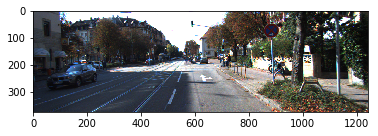

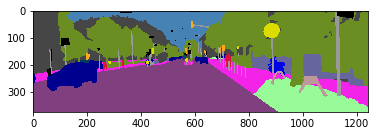

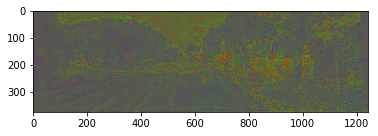

In [30]:
for i_batch, sample_batched in enumerate(dataloader):
    
    
    # Prepare the data
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    inputs_float = inputs.type(torch.FloatTensor)
    labels_float = labels.type(torch.FloatTensor)
    
    
    #Analyse the data 
    print("The inputs size is: ")
    print(inputs_float)
    
    print('\n The groundtruth label size is: ')
    print(labels_float.shape)
   
    #feed the network
    outputs = unet(inputs_float.cuda())
    print("\n The output size is: ")
    print(outputs.dtype)
    print(outputs.shape)
    outputs_prop = torch.exp(outputs)
    print(outputs_prop)
    
    print("The image size is: "+ str(inputs_float.size()) + ". The inputs data type is: " + str(inputs_float.dtype))
    print("The groundtruth mask size is :"+ str(labels.size()) + ". The groundtruth mask type is: " + str(labels_float.dtype))
    print("The predicted mask size is :" +str(outputs.size()) + ". The predicted mask type is " + str(outputs.dtype))
    
    
    #Visualisaton
    show_semantic_batch(sample_batched)
    plt.pause(0.5)
    grid = utils.make_grid(outputs_prop)
    plt.imshow(grid.cpu().detach().numpy().transpose((1,2,0)))

    
    if i_batch == 0:
        
        break

### Define a Loss function and optimizer

In [33]:
import torch.optim as optim
mylr = 0.05
criterion = nn.BCELoss()

### Train the network

In [34]:
for epoch in range(10):
    # loop over the dataset 1 times
    running_loss = 0.0

    optimizer = optim.SGD(unet.parameters(),
                      lr=mylr)

    for i_batch, sample_batched in enumerate(dataloader):
        
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['semantic']
        
        inputs_float = inputs.type(torch.FloatTensor).cuda()
        labels_float = labels.type(torch.FloatTensor)
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward +optimize
        outputs = unet(inputs_float)
        
        outputs_flat = outputs.view(-1)
        
        labels_flat = labels_float.view(-1)
    
        # Define the loss
        loss = criterion(outputs_flat, labels_flat.cuda())      
        loss.backward()
        optimizer.step()
        
        #print statistics
#         running_loss += loss.item()
#         if i_batch%60 == 59: 
#             # print every 20 mini-batchs
#             print('[%d, %5f] loss: %.3f'%(epoch +1, i_batch+1, running_loss/60))
#             running_loss = 0.0
print('Finish Training')

RuntimeError: reduce failed to synchronize: device-side assert triggered

### Visualization after training

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    
    
    # Prepare the data
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    inputs_float = inputs.type(torch.FloatTensor)
    labels_float = labels.type(torch.FloatTensor)
    
    
    #Analyse the data 
    print("The inputs size is: ")
    print(inputs_float)
    
    print('\n The groundtruth label size is: ')
    print(labels_float.shape)
   
    #feed the network
    outputs = unet(inputs_float.cuda())
    print("\n The output size is: ")
    print(outputs.dtype)
    print(outputs.shape)
    outputs_prop = torch.exp(outputs)
    print(outputs_prop)
    
    print("The image size is: "+ str(inputs_float.size()) + ". The inputs data type is: " + str(inputs_float.dtype))
    print("The groundtruth mask size is :"+ str(labels.size()) + ". The groundtruth mask type is: " + str(labels_float.dtype))
    print("The predicted mask size is :" +str(outputs.size()) + ". The predicted mask type is " + str(outputs.dtype))
    
    
    #Visualisaton
    show_semantic_batch(sample_batched)
    plt.pause(0.5)
    grid = utils.make_grid(outputs_prop)
    plt.imshow(grid.cpu().detach().numpy().transpose((1,2,0)))

    
    if i_batch == 0:
        
        break

### cross validation